# Hackathon IBM 2025 - Track Finance - Group 19

Lina Lagzouli

## Librairies import

In [ ]:
import numpy as np
import pandas as pd
import csv
import json
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score,confusion_matrix, ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE


## Merge of the train data

In [ ]:
transactions = pd.read_csv("transactions_train_cleaned.csv")
labels = pd.read_json("train_fraud_labels.json")
cards = pd.read_csv("cards_data_cleaned.csv")
users = pd.read_csv("users_data_cleaned.csv")
with open("mcc_codes.json", "r") as f:
    mcc_codes = json.load(f)

mcc = pd.DataFrame(
    list(mcc_codes.items()),
    columns=["mcc", "mcc_description"]
)


In [ ]:
labels = labels.reset_index()
labels = labels.rename(columns={"index": "transaction_id"})
labels["target"] = labels["target"].map({"Yes": 1, "No": 0})
labels.head()

,transaction_id,target
0,19765990,0
1,22160255,0
2,17566794,0
3,17318690,0
4,20994060,0


In [ ]:
df = transactions.merge(labels, on="transaction_id", how="left")

In [ ]:
users = users.rename(columns={"id": "client_id"})
df = df.merge(users, on="client_id", how="left")

In [ ]:
cards = cards.rename(columns={"id": "card_id"})
df = df.merge(cards, on="card_id", how="left")

In [ ]:
df["mcc"] = df["mcc"].astype(str)
mcc["mcc"] = mcc["mcc"].astype(str)
df = df.merge(mcc, on="mcc", how="left")


## Data transfrormations

In [ ]:
df['merchant_state'] = df['merchant_state'].fillna('online')
df['zip'] = df['zip'].fillna('99999')
df['errors'] = df['errors'].fillna('no')

#%%
import pandas as pd

# --- Conversion en datetime ---
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['expires'] = pd.to_datetime(df['expires'], errors='coerce')
df['date_only'] = pd.to_datetime(df['date_only'], errors='coerce')
df['acct_open_date'] = pd.to_datetime(df['acct_open_date'], errors='coerce')

# --- Colonnes catégorielles ---
categorical_cols = ['card_type', 'card_brand', 'errors']

# Mapping automatique vers des nombres
for col in categorical_cols:
    df[col] = df[col].astype('category')
    df[col + '_num'] = df[col].cat.codes  # création d'une colonne numérique

# --- Colonnes restantes en string (non utilisées pour corrélation) ---
cols_string = ['use_chip', 'merchant_city', 'merchant_state', 'address', 'mcc_description']
df[cols_string] = df[cols_string].astype('string')

# --- Vérification ---
print(df.head())
print(df.dtypes)
#%%
df['date_num'] = df['date'].view('int64')  # nombre de nanosecondes depuis 1970
df['expires_num'] = df['expires'].view('int64')
df['date_only_num'] = df['date_only'].view('int64')
df['acct_open_date_num'] = df['acct_open_date'].view('int64')

   transaction_id                date  client_id_x  card_id  amount  \
0        19765990 2017-07-07 09:53:00         1581     2519   12.35   
1        22160255 2018-11-26 17:44:00         1862     4049   58.29   
2        17566794 2016-03-26 12:42:00         1967     3367   11.03   
3        17318690 2016-02-01 08:30:00          921     3457   85.74   
4        20994060 2018-03-24 14:42:00          456     2800   13.43   

           use_chip  merchant_id merchant_city merchant_state      zip  ...  \
0  Chip Transaction        20519        Arnold             MO  63010.0  ...   
1  Chip Transaction        98648    Des Moines             IA  50313.0  ...   
2  Chip Transaction        46978   Lake Forest             CA  92630.0  ...   
3  Chip Transaction        63701          Rush             NY  14543.0  ...   
4  Chip Transaction        83271        Estero             FL  33928.0  ...   

   cvv has_chip num_cards_issued  credit_limit  acct_open_date  \
0  446        1                1

/tmp/ipython-input-2414881710.py:30: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['date_num'] = df['date'].view('int64')  # nombre de nanosecondes depuis 1970
/tmp/ipython-input-2414881710.py:31: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['expires_num'] = df['expires'].view('int64')
/tmp/ipython-input-2414881710.py:32: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['date_only_num'] = df['date_only'].view('int64')
/tmp/ipython-input-2414881710.py:33: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['acct_open_date_num'] = df['acct_open_date'].view('int64')


In [ ]:
string_cols = ['use_chip', 'merchant_city', 'merchant_state',
               'address', 'mcc_description']

df[string_cols] = df[string_cols].astype("string")


# --- 2) Conversion des dates ---
date_cols = ['date', 'expires', 'date_only', 'acct_open_date']

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col + "_num"] = df[col].view("int64")   # conversion 0→1970 en nanosecondes


# --- 3) Colonnes catégorielles → numériques ---
categorical_cols = ['card_type', 'card_brand', 'errors']

for col in categorical_cols:
    df[col] = df[col].astype("category")
    df[col + "_num"] = df[col].cat.codes


# 4) On supprime les colonnes non numériques pour éviter les erreurs de scaler
to_drop = categorical_cols + string_cols + date_cols

df = df.drop(columns=to_drop)

print(df.dtypes)
df.head()

transaction_id             int64
client_id_x                int64
card_id                    int64
amount                   float64
merchant_id                int64
zip                       object
mcc                       object
target                     int64
current_age                int64
retirement_age             int64
birth_year                 int64
birth_month                int64
latitude                 float64
longitude                float64
per_capita_income        float64
yearly_income            float64
total_debt               float64
credit_score               int64
num_credit_cards           int64
gender_encoded             int64
client_id_y                int64
card_number                int64
cvv                        int64
has_chip                   int64
num_cards_issued           int64
credit_limit             float64
year_pin_last_changed      int64
card_type_num               int8
card_brand_num              int8
errors_num                  int8
date_num  

/tmp/ipython-input-2492185670.py:12: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[col + "_num"] = df[col].view("int64")   # conversion 0→1970 en nanosecondes
/tmp/ipython-input-2492185670.py:12: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[col + "_num"] = df[col].view("int64")   # conversion 0→1970 en nanosecondes
/tmp/ipython-input-2492185670.py:12: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[col + "_num"] = df[col].view("int64")   # conversion 0→1970 en nanosecondes
/tmp/ipython-input-2492185670.py:12: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[col + "_num"] = df[col].view("int64")   # conversion 0→1970 

,transaction_id,client_id_x,card_id,amount,merchant_id,zip,mcc,target,current_age,retirement_age,...,num_cards_issued,credit_limit,year_pin_last_changed,card_type_num,card_brand_num,errors_num,date_num,expires_num,date_only_num,acct_open_date_num
0,19765990,1581,2519,12.35,20519,63010.0,5942,0,38,65,...,1,26596.0,2015,1,3,16,1499421180000000000,1606780800000000000,1499385600000000000,1143849600000000000
1,22160255,1862,4049,58.29,98648,50313.0,5814,0,25,65,...,2,10200.0,2016,0,3,16,1543254240000000000,1693526400000000000,1543190400000000000,1467331200000000000
2,17566794,1967,3367,11.03,46978,92630.0,5411,0,55,74,...,2,38120.0,2011,1,3,16,1458996120000000000,1598918400000000000,1458950400000000000,1180656000000000000
3,17318690,921,3457,85.74,63701,14543.0,5411,0,74,66,...,1,35073.0,2009,1,3,16,1454315400000000000,1588291200000000000,1454284800000000000,1243814400000000000
4,20994060,456,2800,13.43,83271,33928.0,4214,0,54,63,...,1,5800.0,2009,0,3,16,1521902520000000000,1733011200000000000,1521849600000000000,893980800000000000


## Data scaling

In [ ]:
X = df.drop(columns=["target","zip"])
y = df["target"]

scaler = StandardScaler().set_output(transform="pandas")

X = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Inbalanced data

Total count: 210000
Fraud count: 315 (0.15%)
Non-fraud count: 209685 (99.85%)


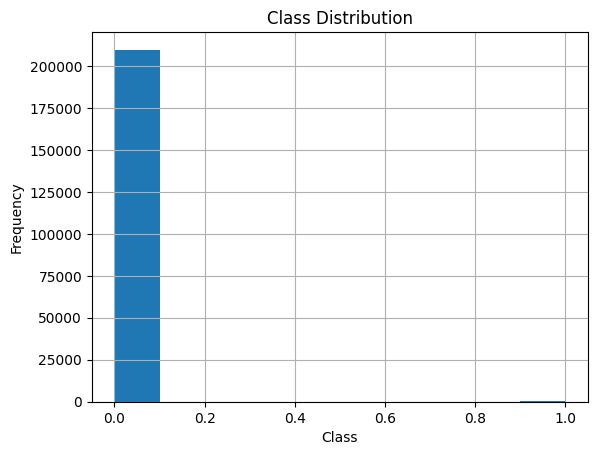

In [ ]:
# --- Quantify imbalance ---
total_count = len(y)

fraud_count = y.sum()                  # nombre de 1
non_fraud_count = total_count - fraud_count

fraud_percentage = (fraud_count / total_count) * 100
non_fraud_percentage = (non_fraud_count / total_count) * 100

print(f"Total count: {total_count}")
print(f"Fraud count: {fraud_count} ({fraud_percentage:.2f}%)")
print(f"Non-fraud count: {non_fraud_count} ({non_fraud_percentage:.2f}%)")


# --- Visualize imbalance ---
df['target'].hist()
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# create a first copy of x_train
x_train1 = x_train.copy()

# Create a balanced set x_train2 using SMOTE
smote = SMOTE(random_state=0)
x_train2, y_train2 = smote.fit_resample(x_train, y_train)

# Create an other balanced set x_train3 using Borderline SMOTE
b_smote = BorderlineSMOTE(random_state=0)
x_train3, y_train3 = b_smote.fit_resample(x_train, y_train)

## Modèles

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)

    print(f"\n{model_name}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"Precision: {prec:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
    disp.plot(cmap='plasma')
    plt.title(f"{model_name}")
    plt.show()

Random Forest


Random Forest - Cost-Sensitive
Accuracy:  0.9985
F1-score:  0.0000
Recall:    0.0000
Precision: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


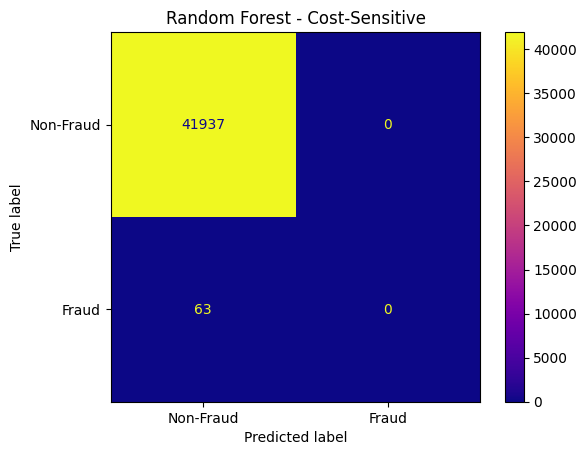

In [ ]:
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
model_rf.fit(x_train1, y_train)

y_pred_rf = model_rf.predict(x_test)
evaluate_model(y_test, y_pred_rf, "Random Forest - Cost-Sensitive")

In [ ]:
# Random Forest - SMOTE Balanced Data
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train2, y_train2)

y_pred_rf_smote = model_rf.predict(x_test)
evaluate_model(y_test, y_pred_rf_smote, "Random Forest - SMOTE")

In [ ]:
# Random Forest - B-SMOTE Balanced Data
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train3, y_train3)

y_pred_rf_bsmote = model_rf.predict(x_test)
evaluate_model(y_test, y_pred_rf_bsmote, "Random Forest - B-SMOTE")

In [ ]:
# Linear SVM - SMOTE Balanced Data
model_svm = LinearSVC(random_state=42, max_iter=10000)
model_svm.fit(x_train2, y_train2)

y_pred_svm_smote = model_svm.predict(x_test)

evaluate_model(y_test, y_pred_svm_smote, "Linear SVM - SMOTE")


In [ ]:
# SVM - B-SMOTE Balanced Data
model_svm = LinearSVC(random_state=42, max_iter=10000)
model_svm.fit(x_train3, y_train3)

# Prédictions
y_pred_svm_bsmote = model_svm.predict(x_test)

# Évaluation du modèle
evaluate_model(y_test, y_pred_svm_bsmote, "Linear SVM - B-SMOTE")
